In [1]:
%reset

### data for traning

In [2]:
import scipy.io
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from torch.utils.data import DataLoader
from itertools import chain
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from torch.nn.functional import normalize

/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mat = scipy.io.loadmat('data_031022_A431_mwell_adhesion_ordered.mat')

In [4]:
print('The file contains:', mat.keys())
print('Count of wavanumber:', len(mat['wavnum'][0]))
print('The wavanumber:', mat['wavnum'][0])
# The first 41 spectra correspond to t=1 to t=41 for well 1 etc.
# For this particular experiment, the different wells were used for different surface coatings: 
# wells 1-4: uncoated, wells 5-8: FBS coated, wells 9-12: fibronectin coated, and wells 13-16: poly-D-lysine coated.

The file contains: dict_keys(['__header__', '__version__', '__globals__', 'data_d0abs_031022_adhesion_ordered', 'data_d2abs_031022_adhesion_ordered', 'wavnum'])
Count of wavanumber: 1200
The wavanumber: [3612.20117605 3610.27261162 3608.34404719 ... 1155.21009314 1153.28152871
 1151.35296428]


In [5]:
# visualise data
#X_i = pd.DataFrame(mat['data_d0abs_031022_adhesion_ordered'])
#X_i.plot(legend=False)

In [6]:
# could apply noise to augment data

### apply PCA on global time series data

In [7]:
# a draw of picture here

In [8]:
X_0 = pd.DataFrame(mat['data_d0abs_031022_adhesion_ordered'])
X_0.columns = mat['wavnum'][0]
print('The raw matrix is', X_0.shape)

The raw matrix is (656, 1200)


In [9]:
print("plasmonic resonance ", "range(639, 840)")
print("protein ", "range(859,1020)")
print("lipid", "range(284, 445)")
#print("tricarbonyl", range((1200-(3064-1151)//2.05),(1200-(2756-1151)//2.05)))

plasmonic resonance  range(639, 840)
protein  range(859,1020)
lipid range(284, 445)


In [10]:
def get_loadings(X_0, rang=range(859,1020)):
    
    sc = StandardScaler()
    X_0 = pd.DataFrame(sc.fit_transform(X_0))

    # input is range of the spectral window
    indices = list(chain(rang))
    x01 = X_0.iloc[:, indices]
    # subset of rows
    row_idx = list(chain(range(0,41), range(164,205), range(328,369), range(492,533)))
    # row_idx = list(chain(range(0,41)))
    x011 = x01.iloc[row_idx,:]
    x011 = x01


    # run PCA
    # Sum_Explained_variance =.99
    # pca = PCA(Sum_Explained_variance)
    torch.manual_seed(42)
    N_Compents = 2
    pca = PCA(n_components=N_Compents)
    X_i = x011
    X2_data =pca.fit_transform(X_i)
    N_Compents=pca.n_components_ 
#     print(X2_data.shape)
#     print(N_Compents)
    
    #print
    explained_variance = pca.explained_variance_ratio_
    print("explained_variance", explained_variance)
    
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings = pd.DataFrame(loadings)
    print('loadings:',loadings.shape,'explained_variance_:', pca.explained_variance_.shape)
    
    return loadings, x01, N_Compents

In [11]:
protein_loadings, x01_proteins, N_Compents_proteins = get_loadings(X_0, rang=range(862,1018))
# proteins (green, 1499<ω<1807 cm−1)

explained_variance [0.58155221 0.2567855 ]
loadings: (156, 2) explained_variance_: (2,)


/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Here, we subselect the protein window, and all categories of whole time series t1-t41 for PCA


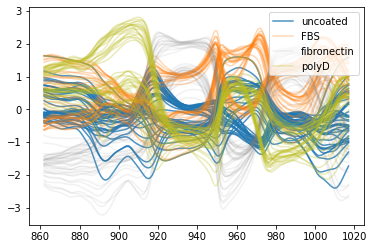

In [12]:
print('Here, we subselect the protein window, and all categories of whole time series t1-t41 for PCA')
plt.plot(x01_proteins.iloc[0:41,:].T,color='C0',alpha=0.8,label='uncoated')
plt.plot(x01_proteins.iloc[164:205,:].T,color='C1',alpha=0.3,label='FBS')
plt.plot(x01_proteins.iloc[328:369,:].T,color='C7',alpha=0.1,label='fibronectin')
plt.plot(x01_proteins.iloc[492:533,:].T,color='C8',alpha=0.3,label='polyD')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(list(np.array(handles)[[0,41,82,133]]), list(np.array(labels)[[0,41,82,133]]), loc='upper right')
plt.show()

In [13]:
lipid_loadings, x01_lipids, N_Compents_lipids = get_loadings(X_0, rang=range(285, 445)) #284, 445
# lipids (2756<ω<3064 cm−1).

explained_variance [0.70070253 0.27165282]
loadings: (160, 2) explained_variance_: (2,)


/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


In [14]:
plasmonic_loadings, x01_plasmonic, N_Compents_plasmonic = get_loadings(X_0, rang=range(639,838)) #639,838/770
# plasmonic resonance (1978<ω<2231 cm−1)
# plasmonic resonance (1845<ω<2231 cm−1)

explained_variance [0.94336452 0.04670213]
loadings: (199, 2) explained_variance_: (2,)


/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Here, we subselect the plasmonic window, and all categories of whole time series t1-t41 for PCA


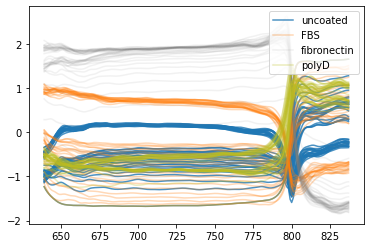

In [15]:
print('Here, we subselect the plasmonic window, and all categories of whole time series t1-t41 for PCA')
plt.plot(x01_plasmonic.iloc[0:41,:].T,color='C0',alpha=0.8,label='uncoated')
plt.plot(x01_plasmonic.iloc[164:205,:].T,color='C1',alpha=0.3,label='FBS')
plt.plot(x01_plasmonic.iloc[328:369,:].T,color='C7',alpha=0.1,label='fibronectin')
plt.plot(x01_plasmonic.iloc[492:533,:].T,color='C8',alpha=0.3,label='polyD')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(list(np.array(handles)[[0,41,82,133]]), list(np.array(labels)[[0,41,82,133]]), loc='upper right')
plt.show()

### arrange the multi-temporal-spectral data for inputting into the LSTM

In [16]:
def get_objectwise(X_uncoated, loadings):
    
    X_uncoated.columns = range(len(loadings))
    X_j = X_uncoated.dot(loadings)
    n = 41  #chunk row size
    list_df_j = [X_j[i:i+n].T for i in range(0,X_j.shape[0],n)]
    return list_df_j

def get_projections(x01,loadings):
    n = 41*4  #chunk row size
    list_df = [x01[i:i+n] for i in range(0,x01.shape[0],n)]
    #projected along the PC loadings by matrix multiplication 
    X_uncoated = list_df[0]
    X_FBS = list_df[1]
    X_fibro = list_df[2]
    X_polyD = list_df[3]
    
    list_objs = []
    for _ in [X_uncoated, X_FBS, X_fibro, X_polyD]:
        list_df_j = get_objectwise(_, loadings = loadings)
        list_objs.append(list_df_j)
        
    return list_objs

In [17]:
list_objs_proteins = get_projections(x01=x01_proteins,loadings=protein_loadings)

In [18]:
list_objs_lipids = get_projections(x01=x01_lipids,loadings=lipid_loadings)

In [19]:
list_objs_plasonic= get_projections(x01=x01_plasmonic,loadings=plasmonic_loadings)

### traning process

The structure of the LSTM network consists of a sequence input layer, followed by a blocks containing a long short-term memory (LSTM) layer and a dropout layer, a fully connected (FC) layer, a softmax layer and finally an output layer

In [20]:
def as_torch(list_objs,N_Compents,name):
    dataX = Variable(torch.Tensor(np.array(list_objs)))
    #flatten 4 category *  4 replicates
    PC = N_Compents
    shape = (4, 4, PC, 41)
    dataX = dataX.view(tuple((-1, *shape[2:])))
    print("inputs_{}_windows: ".format(name), dataX.shape)
    
    return dataX

In [21]:
dataX_proteins = as_torch(list_objs_proteins, N_Compents=N_Compents_proteins, name="proteins")
dataX_lipids= as_torch(list_objs_lipids, N_Compents=N_Compents_lipids, name="lipids")
dataX_plasmonic= as_torch(list_objs_plasonic, N_Compents=N_Compents_plasmonic, name="plasmonic")

inputs_proteins_windows:  torch.Size([16, 2, 41])
inputs_lipids_windows:  torch.Size([16, 2, 41])
inputs_plasmonic_windows:  torch.Size([16, 2, 41])


In [22]:
# select last 10 time points can also give high accuracy
# dataX_proteins = dataX_proteins[:, :, :10]
# dataX_proteins = dataX_proteins[:, :, -10:]
# dataX_plasmonic = dataX_plasmonic[:, :, -20:]

In [23]:
# dataX = torch.cat([dataX_proteins, dataX_plasmonic], dim=1)
dataX = torch.cat([dataX_proteins], dim=1)
# dataX = torch.cat([dataX_plasmonic], dim=1)
# dataX = torch.cat([dataX_lipids], dim=1)
dataX.shape

torch.Size([16, 2, 41])

In [24]:
y = np.array([[0,1,2,3]])
y = np.repeat(y, 4)
dataY = Variable(torch.Tensor(np.array(y))).view(16,1)
print("targets ", dataY.shape)

targets  torch.Size([16, 1])


### LSTM

In [25]:
#https://wmathor.com/index.php/archives/1402/
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # dropout & biLSTM
        #, bidirectional=True
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bidirectional=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        

        self.NN = nn.Sequential(
            nn.Linear(self.hidden_size*2, num_classes),          
            # nn.Sigmoid()
        )
        
#https://wmathor.com/index.php/archives/1447/
    def forward(self, x):
        # In_Lstm = x
        In_Lstm = x.transpose(0, 1)  # input:[max_len, batch_size, n_class]
        # In_Lstm = self.dropout(In_Lstm)
        batch_size = x.shape[0]

        h0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size) #h0, c0:(num_layers, batch_size, hidden_size)

        ula, (hidden, _) = self.lstm(In_Lstm,(h0, c0))

        # ula = ula[-1] # [batch_size, n_hidden * 2]
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        out = self.NN(hidden)

        return out

In [26]:
torch.manual_seed(42)
# Configuration options
print(dataX.shape)
input_size = dataX.shape[1] #Number of features used as input. (Number of columns)
hidden_size = 64 #more hidden units, longer time remembered
num_layers = 1
num_classes = 4
num_epochs = 15
batch_size = 4

learning_rate = 3e-4

model = LSTM(num_classes, input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

model

torch.Size([16, 2, 41])


/opt/miniconda3/envs/synergyy/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(2, 64, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (NN): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [27]:
def main(dataX):
    torch.manual_seed(2013)
    #Configurations on k folds
    k_folds = 4
    #dataX.permute(0, 2, 1)
    whole_dataset = torch.utils.data.TensorDataset(*[dataX.permute(0, 2, 1), dataY])

    # Define the K-fold Cross Validator
    # kfold = KFold(n_splits=k_folds, random_state=42, shuffle=True)
    kfold = StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    # Start print
    print('--------------------------------')

    saliency_lists, actual_list, predict_list = [], [], []
    test_acc = {}

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(whole_dataset,dataY)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        trainloader = DataLoader(whole_dataset, batch_size=batch_size, sampler=train_subsampler)
        valloader = DataLoader(whole_dataset,batch_size=batch_size, sampler=test_subsampler)

        # init para for each fold  
        for layer in model.modules():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        # Train the model
        results = {}
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = []
            train_correct = 0
            for i, (inputs, target) in enumerate(trainloader, 0):
                optimizer.zero_grad()
                #get prediction
                output = model(inputs)
                output_idx = output.max(1, keepdim=True)[1]  # get the index of the max logit
                target = target.type(torch.LongTensor)
                # obtain the loss function
                loss = criterion(output, target.squeeze())
                #backward
                loss.backward()
                optimizer.step()

                train_correct = torch.sum(output_idx==target)
                train_loss.append(loss.detach()/batch_size)

            if epoch%5==0:
                print("train loss", np.round(np.mean(train_loss),5), "train accuracy {}/{}".format(np.round(train_correct).numpy(),len(target)))

            results[epoch] = np.round(np.mean(train_loss))

            # Saving the best model
            if results[epoch] <= min(results.values()):
                save_path = os.path.join('best_model_%s.pth' % 'lstm')
                torch.save(model.state_dict(), save_path)
                model_weigths = model.state_dict()
                
        # validation
        model.eval()
        model.load_state_dict(model_weigths)
        val_correct = 0.0
        actuals = []
        predicts = []
        saliencys = []

        with torch.no_grad():
            for i, (dt, ts) in enumerate(valloader, 0):
                pred = model(dt)
                zs = pred.max(1, keepdim=True)[1]
                val_correct += torch.sum(zs==ts)
                actuals.append(ts.squeeze())
                predicts.append(zs.squeeze())
            
                # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
                # dt.requires_grad_()
                # scores = model(dt)
                
                # # logits = model.forward(X)
                # # logits = logits.gather(1, y.view(-1, 1)).squeeze() # correct classification
                # # logits.backward(torch.FloatTensor([1., 1., 1., 1., 1.])) 

                # # Get the index corresponding to the maximum score and the maximum score itself.
                # score_max, index= torch.max(scores,1)
                # score_max = score_max.reshape(-1,1)

                # #backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
                # #score_max with respect to nodes in the computation graph
                # score_max.backward(torch.ones_like(score_max))

                # #construct sailency map
                # saliency = dt.grad.data.abs()
                # #save individual map within each batch
                # for i in range(batch_size):
                #     saliencys.append(torch.split(saliency, batch_size)[0][i].squeeze().T)
                        

        actuals = [val for sublist in np.vstack(list(chain(*actuals))) for val in sublist]
        predicts = [val for sublist in np.vstack(list(chain(*predicts))) for val in sublist]
        
        actual_list.append(actuals)
        predict_list.append(predicts)
        saliency_lists.append(saliencys)
        
        test_acc[fold] = (np.round(val_correct).numpy()/len(actuals))
        # saliency_maps = [val for sublist in np.vstack(list(chain(*saliency_maps))) for val in sublist]
        
        print("validation accuracy {}/{}".format(np.round(val_correct).numpy(), len(actuals)), "predicts: ", predicts, "labels: ", actuals)

        #     print(f'Epoch {epoch}/{num_epochs} ---train loss {np.round(np.mean(train_loss),5))})
        #         --- val correct {np.round(val_correct)})
    return test_acc,actual_list,predict_list

In [28]:
test_acc,actual_list,predict_list = main(dataX=dataX)

--------------------------------
FOLD 0
--------------------------------
train loss 0.31179 train accuracy 0/4
train loss 0.28507 train accuracy 2/4
train loss 0.2871 train accuracy 3/4
validation accuracy 4.0/4 predicts:  [2, 0, 3, 1] labels:  [2.0, 0.0, 3.0, 1.0]
FOLD 1
--------------------------------
train loss 0.33433 train accuracy 2/4
train loss 0.32068 train accuracy 3/4
train loss 0.27905 train accuracy 2/4
validation accuracy 4.0/4 predicts:  [3, 2, 0, 1] labels:  [3.0, 2.0, 0.0, 1.0]
FOLD 2
--------------------------------
train loss 0.35977 train accuracy 0/4
train loss 0.30247 train accuracy 1/4
train loss 0.29291 train accuracy 1/4
validation accuracy 4.0/4 predicts:  [2, 3, 0, 1] labels:  [2.0, 3.0, 0.0, 1.0]
FOLD 3
--------------------------------
train loss 0.36724 train accuracy 1/4
train loss 0.33017 train accuracy 1/4
train loss 0.28678 train accuracy 4/4
validation accuracy 4.0/4 predicts:  [1, 2, 0, 3] labels:  [1.0, 2.0, 0.0, 3.0]


Text(0.5, 1.0, 'Protein window')

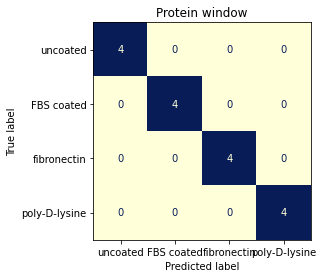

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test = [val for sublist in np.vstack(list(chain(*actual_list))) for val in sublist]
predictions = [val for sublist in np.vstack(list(chain(*predict_list))) for val in sublist]
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['uncoated','FBS coated','fibronectin','poly-D-lysine'])
disp.plot(cmap='YlGnBu',  colorbar=False)
plt.title('Protein window')

In [ ]:
##  calculate acurracy of test dataset according to different length of PR window
acc_PRlen = {}
# plasmonic resonance (1845<ω<2231 cm−1)
for i in range(20):
    endpoint = 838-i*10
    print(endpoint)
    wavelength = mat['wavnum'][0][endpoint]

    plasmonic_loadings, x01_plasmonic, N_Compents_plasmonic = get_loadings(X_0, rang=range(639,838-i*10))
    list_objs_plasonic= get_projections(x01=x01_plasmonic,loadings=plasmonic_loadings)
    dataX_plasmonic= as_torch(list_objs_plasonic, N_Compents=N_Compents_plasmonic, name="plasmonic")
    test_acc,actual_list,predict_list = main(dataX=dataX_plasmonic)

    acc_PRlen[wavelength] = np.mean(list(test_acc.values()))

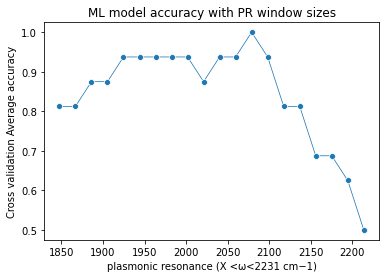

In [40]:
#
acc_PRlen_df = pd.DataFrame(acc_PRlen.items(), columns=['wavelength', 'test_accuracy'])
acc_PRlen_df['event'] = 1
g = sns.lineplot(data=acc_PRlen_df, x="wavelength", y="test_accuracy",markers=True, style="event",size=5)
g.set(xlabel='plasmonic resonance (X <ω<2231 cm−1)', ylabel='Cross validation Average accuracy')
g.set_title('ML model accuracy with PR window sizes')
g.get_legend().remove()

In [41]:
acc_PRlen

{1847.5647232533: 0.8125,
 1866.8503675461: 0.8125,
 1886.1360118389: 0.875,
 1905.4216561317: 0.875,
 1924.7073004246: 0.9375,
 1943.9929447174: 0.9375,
 1963.2785890102: 0.9375,
 1982.5642333031: 0.9375,
 2001.8498775959: 0.9375,
 2021.1355218887: 0.875,
 2040.4211661816: 0.9375,
 2059.7068104744: 0.9375,
 2078.9924547672: 1.0,
 2098.2780990601: 0.9375,
 2117.5637433529: 0.8125,
 2136.8493876457: 0.8125,
 2156.1350319386: 0.6875,
 2175.4206762314: 0.6875,
 2194.7063205242: 0.625,
 2213.991964817: 0.5}

In [33]:
# #chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1506.01066v2.pdf
# fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(20,10))
# for i in range(len(predict_list)):
#     for j in range(len(predict_list[0])):
        
#         idx = predict_list[i][j]
        
#         old_tensor = saliency_lists[i][idx]
#         # compute variance row-wise (along time step)
#         # normalize row-wise
#         t2 = normalize(old_tensor, p=1.0, dim = 1)
#         sns.heatmap(t2,  cmap="Blues", ax=axes[i][j])
#         # sns.heatmap(old_tensor,  cmap="Blues", ax=axes[i][j])
#         # axes[i][idx].set_xlim(0, 41) 
#         axes[i][idx].set_title("fold" + str(i) + ", true label: " + str(idx))

# fig.suptitle('Figure a: Saliency heatmap for each validation set(4 samples) in 4 folds (4 rows* 4 columns). \n \
#     Within a subplot, each row corresponds to normalized saliency scores for the correspondent 3 PC dimensions \
# with each grid representing 41 time steps.')


In [34]:
# rnn = nn.LSTM(input_size=9, hidden_size=3, batch_first=True,num_layers=1)
# input = torch.randn(4,41,9)
# h0 = torch.randn(1, 4, 3)
# c0 = torch.randn(1, 4, 3)
# output, (hn, cn) = rnn(input, (h0, c0))
# hn.view(-1, 3)


In [35]:
# #https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4
# for i, (dt, ts) in enumerate(valloader, 0):
#     # print(ts) randomsampler changes every time
#     model.eval()
#     # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
#     dt.requires_grad_()
#     scores = model(dt)
    
#     # Get the index corresponding to the maximum score and the maximum score itself.
#     score_max, index= torch.max(scores,1)
#     score_max = score_max.reshape(-1,1)

#     #backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
#     #score_max with respect to nodes in the computation graph
#     score_max.backward(torch.ones_like(score_max))

#     #construct sailency map
#     saliency = dt.grad.data.abs()
#     # saliency,_ = torch.max(dt.grad.data.abs(), dim=2)
#     # sns.heatmap(torch.split(saliency, 4)[0][3].squeeze().T,  cmap="Blues")